## Dimensionality reduction with principle components

In [104]:
import pandas as pd
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
import sklearn.decomposition as skde
import numpy as np
import numpy.random as nr
import matplotlib.pyplot as plt
import math

%matplotlib inline

In [105]:
nr.seed(124)
cov = np.array([[1.0, 0.6], [0.6, 1.0]])
mean = np.array([0.0, 0.0])

sample = nr.multivariate_normal(mean, cov, 100)
sample.shape

(100, 2)

Text(0.5,1,'Sample data')

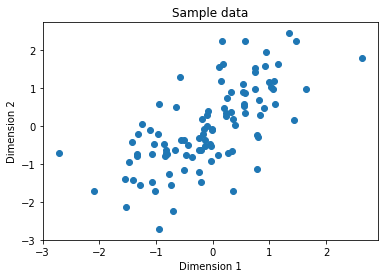

In [106]:
plt.scatter(sample[:,0], sample[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

In [107]:
pca_model = skde.PCA()
pca_fit = pca_model.fit(sample)
print(pca_fit.explained_variance_ratio_)

[0.84530942 0.15469058]


In [108]:
comps = pca_fit.components_
print(comps)
for i in range(2):
    comps[:,i] = comps[:,i] * pca_fit.explained_variance_ratio_
print(comps)

[[ 0.60552007  0.79583003]
 [-0.79583003  0.60552007]]
[[ 0.51185182  0.67272262]
 [-0.12310741  0.09366825]]


Text(0.5,1,'Sample data')

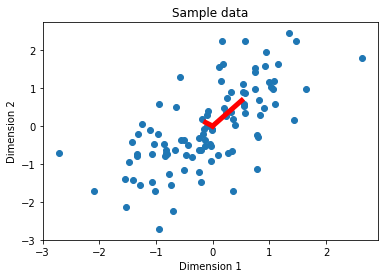

In [109]:
plt.scatter(sample[:,0], sample[:,1])
plt.plot([0.0, comps[0,0]], [0.0,comps[0,1]], color = 'red', linewidth = 5)
plt.plot([0.0, comps[1,0]], [0.0,comps[1,1]], color = 'red', linewidth = 5)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

Text(0.5,1,'Sample data')

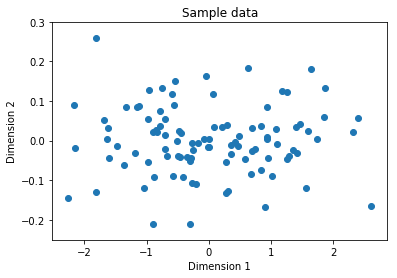

In [110]:
trans = pca_fit.transform(sample)
plt.scatter(trans[:,0], trans[:,1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Sample data')

### Load Features and Labels

In [111]:
Features = np.array(pd.read_csv('Credit_Features.csv'))
Labels = np.array(pd.read_csv('Credit_Labels.csv'))
print(Features.shape)
print(Labels.shape)

(999, 35)
(999, 1)


In [112]:
## Randomly sample cases to create independent training and test data
nr.seed(1115)
indx = range(Features.shape[0])
indx = ms.train_test_split(indx, test_size = 300)
x_train = Features[indx[0],:]
y_train = np.ravel(Labels[indx[0]])
x_test = Features[indx[1],:]
y_test = np.ravel(Labels[indx[1]])

## Compute principle components

In [113]:
pca_mod = skde.PCA()
pca_comps = pca_mod.fit(x_train)
pca_comps

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [114]:
print(pca_comps.explained_variance_ratio_)

[2.10371317e-01 1.41889525e-01 1.30416485e-01 5.29255602e-02
 4.58877065e-02 4.54231655e-02 4.01315388e-02 3.75523632e-02
 3.27679657e-02 3.15220744e-02 2.78790155e-02 2.68014992e-02
 2.43754088e-02 2.14515760e-02 1.74960773e-02 1.66840809e-02
 1.59279550e-02 1.48172414e-02 1.25291687e-02 1.03074323e-02
 9.25893998e-03 7.31621592e-03 6.92297009e-03 6.02021439e-03
 5.17958679e-03 3.83751243e-03 1.73470316e-03 1.34224772e-03
 1.23045274e-03 4.14884269e-32 3.16981128e-33 2.84951011e-33
 1.20251621e-33 1.20251621e-33 1.20251621e-33]


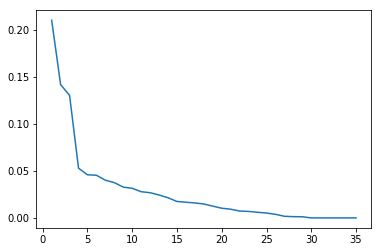

In [115]:
def plot_explained(mod):
    comps = mod.explained_variance_ratio_
    x = range(len(comps))
    x = [y + 1 for y in x]          
    plt.plot(x,comps)

plot_explained(pca_comps)

## Transform the features

In [116]:
pca_mod_5 = skde.PCA(n_components = 5)
pca_mod_5.fit(x_train)
Comps = pca_mod_5.transform(x_train)
Comps.shape

(699, 5)

In [117]:
## define and fit the linear regression model
lin_mod = linear_model.LogisticRegression(C = 100) 
lin_mod.fit(Comps, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [118]:
print(lin_mod.intercept_)
print(lin_mod.coef_)

[-0.97769488]
[[ 0.33601464 -0.05883983 -0.44568484  1.10634656 -0.53374788]]


## Evaluate the model

In [119]:
def print_metrics(labels, scores):
    metrics = sklm.precision_recall_fscore_support(labels, scores)
    conf = sklm.confusion_matrix(labels, scores)
    print('                 Confusion matrix')
    print('                 Score positive    Score negative')
    print('True positive    %6d' % conf[0,0] + '          %5d' % conf[0,1])
    print('True negative    %6d' % conf[1,0] + '          %5d' % conf[1,1])
    print('')
    print('Accuracy  %0.2f' % sklm.accuracy_score(labels, scores))
    print(' ')
    print('             Positive   Negative')
    print('Num case    %0.2f' % metrics[3][0] + '       %0.2f' % metrics[3][1])
    print('Precision   %0.2f' % metrics[0][0] + '          %0.2f' % metrics[0][1])
    print('Recall      %0.2f' % metrics[1][0] + '          %0.2f' % metrics[1][1])
    print('F1          %0.2f' % metrics[2][0] + '          %0.2f' % metrics[2][1])

def score_model(probs, threshold):
    return np.array([1 if x > threshold else 0 for x in probs[:,1]])

probabilities = lin_mod.predict_proba(pca_mod_5.transform(x_test))
scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)    

                 Confusion matrix
                 Score positive    Score negative
True positive       139             78
True negative        30             53

Accuracy  0.64
 
             Positive   Negative
Num case    217.00       83.00
Precision   0.82          0.40
Recall      0.64          0.64
F1          0.72          0.50


## Add more components


In [120]:
pca_mod_10 = skde.PCA(n_components = 10)
pca_mod_10.fit(x_train)
Comps_10 = pca_mod_10.transform(x_train)
Comps_10.shape

(699, 10)

In [121]:
## define and fit the linear regression model
lin_mod_10 = linear_model.LogisticRegression(C = 100) 
lin_mod_10.fit(Comps_10, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [122]:
probabilities = lin_mod_10.predict_proba(pca_mod_10.transform(x_test))
scores = score_model(probabilities, 0.3)
print_metrics(y_test, scores)  

                 Confusion matrix
                 Score positive    Score negative
True positive       145             72
True negative        19             64

Accuracy  0.70
 
             Positive   Negative
Num case    217.00       83.00
Precision   0.88          0.47
Recall      0.67          0.77
F1          0.76          0.58
